# <strong> Language as a Cognitive Tool to Imagine Goals in Curiosity Driven Exploration </strong>

--------------------------------------------------------------------------------


This notebook is a walk-through the *IMAGINE* learning algorithm, from the [Language as a Cognitive Tool to Imagine Goals in Curiosity Driven Exploration](https://arxiv.org/pdf/2002.09253.pdf) paper.

_We argue that the ability to imagine out-of-distribution goals is key to enable creative discoveries and open-ended learning. Children do so by leveraging the compositionality of language as a tool to imagine descriptions of outcomes they never experienced before, targeting them as goals during play._

#### <strong> The IMAGINE Setup </strong>

The IMAGINE setup can be decomposed into two phases:

* **Phase 1**: The agent starts with no prior knowledge on the set of possible interactions with its environment. It first explores randomly, then pursues its own goals as it discovers interesting interactions. A social partner (SP) provides linguistic descriptions of interesting interactions performed by the agent. These descriptions are turned into targetable goals by the agent. To represent goals, the agent trains jointly a language encoder that converts linguistic inputs to goal embeddings and a language-conditioned reward function.

* **Phase 2**: The agent starts to imagine goals by composing known ones. It can train on them autonomously using learning signals from the internal reward function learned during Phase 1.

<img src="https://drive.google.com/uc?id=1Xre-pH-r5lXaT9kv33zTIOLrnpUelgNy" width="600"/>

#### <strong> The IMAGINE Architecture </strong>

1. The Goal Generator samples a target goal $g_{target}$ from the set of discovered and imagined goals ($\mathcal{G}_d \cup \mathcal{G}_{im}$).
2. The agent interacts with the environment (RL Agent) using its policy $\pi$ conditioned by a goal embedding $g_{target}$.
3. The state-action trajectories are stored in $mem(\pi)$.
4. SP observes the final state of the episode ($s_{T}$) and provides descriptions $\mathcal{D}_{SP}(s_T)$ that the agent turns into targetable goals $\mathcal{G}_{SP}(s_T)$.
5. $mem(\mathcal{R})$ stores positive pairs ($s_T,\mathcal{G}_{SP}(s_T)$)and infersnegative pairs($s_T,\mathcal{G}_\text{na}(s_T)$).
6.  The agent then updates:
  - Goal Generator: Newly discovered goals are added to the set of known goals $\mathcal{G_\text{known}} \leftarrow \mathcal{G}_\text{known} \cup \mathcal{G}_{SP}(s_T)$. If the agent is allowed to imagine new goals: $\mathcal{G}_{im} \leftarrow \text{Imagination}(\mathcal{G_\text{known}})$.
  - Language Encoder($L_e$) and Reward Function ($\mathcal{R}$): updated using data from $mem(\mathcal{R})$.
  - RL agent(actor and critic):  A batch of state-action transitions $(s,a,s′)$ is sampled from $mem(\pi)$.  Then Hindsight Replay and $\mathcal{R}$ are used to select goals to train on and compute rewards $(s,a,s,g_{NL},r)$. Finally, the policy and critic are trained via RL.


Configuring everything:

In [1]:
%%capture

import numpy as np
import torch
import random
import gym
import pygame
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
from IPython.display import HTML
import os
# os.environ['SDL_VIDEODRIVER'] = 'dummy'
# os.environ['SDL_AUDIODRIVER'] = 'dummy'
from src.imagine.experiment import config
from src.imagine.goal_sampler import GoalSampler
from src.utils.notebook_utils import get_params_for_notebook, get_modules_for_notebook, generate_animation_reward_module,\
generate_animation_policy_module, plot_tsne


path= 'pretrained_weights/'
params = get_params_for_notebook(path)
policy_language_model, reward_language_model, policy, reward_function, goal_sampler = get_modules_for_notebook(path, params)

## <strong> 1. IMAGINE under the hood </strong>

------------------------------------------------

#### <strong> 1.1.1 First Role of the Social Partner: Setting Up The Scene </strong>


The first role of the Social Partner (SP) is to set up the scene so that the goal targeted by the agent can be achieved.

SP provides the agent with optimal learning opportunities by organizing the scene with:
1. The required objects to reach the goal (not too difficult)
2. Procedurally-generated distracting objects (not too easy and providing further discovery opportunities)

The following lines of code show how scenes are generated according to this assumption:


In [2]:
# Enter a valid goal description
goal_str = 'Grow blue cat' #Grow red cat, Grasp blue sofa, Grow green cow ...
# Uncomment to sample a random goal from the training set
# goal_str = np.random.choice(params['train_descriptions'])
assert goal_str in params['train_descriptions'], 'Please enter a feasible goal description.'

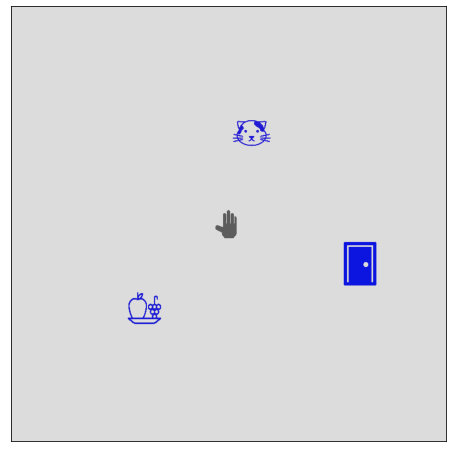

In [3]:
# Generating a scene which is compatible with the goal description
env = gym.make(params['conditions']['env_name'], display=False)
env.reset()
initial_o = env.unwrapped.reset_with_goal(goal_str)
env.step(np.array([0, 0, 0]))
env.render(close=True)
obs = pygame.surfarray.array3d(env.viewer).transpose([1,0,2])

plt.rcParams['figure.figsize'] = [12, 8]
fig = plt.imshow(obs)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

We observe that the generated scene contains the object specified in the goal description as well as two distractor objects.

Note that if your 'goal_str' implies growing an animal, the social partner also takes care of setting up with either food or water to grow it.

#### <strong> 1.1.2 Second Role of the Social Partner: Providing Descriptions</strong>



The second role of the social partner is to provide language descriptions about the goals reached by the agent __at the end of an episode__.

In this section, we play a policy conditioned by the goal we defined in 1.1.1 and observe the descriptive feedback given by the social partner at the end of the episode.

We first do the rollout of the policy:

In [4]:
def generate_animated_rollout(env, goal_str, initial_o, policy, policy_language_model, reset=False):
    # In order to build vizualization
    fig = plt.figure()
    ims = []

    ## Rollout of a policy
    if reset:
        env.reset()
        initial_o = env.unwrapped.reset_with_goal(goal_str)
        o = initial_o.copy()
    else:
        o = initial_o.copy()
    goal_encoding = policy_language_model.encode(goal_str)
    episode={'obs':[]}
    for t in range(30):
        action = policy.get_actions(o, goal_encoding)
        o,_,_,_ = env.step(action)
        episode['obs'].append(o)
        env.render(close=True)
        obs = pygame.surfarray.array3d(env.viewer).transpose([1,0,2])
        plt.rcParams['figure.figsize'] = [12, 8]
        im = plt.imshow(obs, animated=True)
        ims.append([im])
      
    ani = animation.ArtistAnimation(fig, ims, interval=400, blit=False,
                                  repeat=False)
    return ani, episode, o, obs

In [5]:
%%capture
ani, episode, o, obs = generate_animated_rollout(env, goal_str, initial_o, policy, policy_language_model)

In [6]:
HTML(ani.to_html5_video())

__Exhaustive feedback:__

In its default configuration, the social partner gives __exhaustive feedbacks__: it outputs all the goals that the agent has achieved at the end of the episode. 

In [7]:
from src.imagine.social_partner import SocialPartner
oracle_reward_function = config.get_oracle_reward_function(goal_sampler, params)
social_partner = SocialPartner(oracle_reward_function=oracle_reward_function,
                               goal_sampler=goal_sampler,
                               feedback_strategy='exhaustive',
                               p_availability=1.,
                               params=params)
exhaustive_feedback = social_partner.get_feedback([episode])[0][0]
pd.DataFrame(exhaustive_feedback, columns=['Descriptive Feedback from Social Partner'])

,Descriptive Feedback from Social Partner
0,Go left
1,Go bottom
2,Go bottom left
3,Grasp blue living_thing
4,Grasp blue cat
5,Grasp any blue thing
6,Grasp any living_thing
7,Grasp any cat
8,Grow blue animal
9,Grow blue cat


The agent can then infer the negative feedbacks by contrasting the set of goals already discovered and the set of goals achieved in the episode:

In [8]:
negative_examples = set(goal_sampler.feedback_memory['string']) - set(exhaustive_feedback)
negative_examples = pd.DataFrame(negative_examples, columns=['Negative examples'])
negative_examples.head(7)

,Negative examples
0,Grasp red food
1,Grasp red rose
2,Grow green bonsai
3,Grow blue window
4,Grow any sofa
5,Go center right
6,Grasp any carnivorous


__One positive example and one negative one__:

In our paper, we relax the exhaustive feedback configuration and train our system with a social partner giving only one positive and one negative feedback at the end of each episode. 

Here is an example of how the social partner operates in that configuration:

In [9]:
social_partner2 = SocialPartner(oracle_reward_function=oracle_reward_function,
                                goal_sampler=goal_sampler,
                                feedback_strategy='one_pos_one_neg',
                                p_availability=1.,
                                params=params)

pos, neg = social_partner2.get_one_pos_one_neg_feedback([episode])

# one_pos_one_neg_df = 
pd.DataFrame({'Positive feedback': pos, 'Negative feedback':neg })

,Positive feedback,Negative feedback
0,Grow blue animal,Grasp red lamp


We observe that the generated scene contains the object of the specified goal description as well as two distractor objects.

### <strong> 1.2 The Reward Function Module </strong>

------------

#### <strong> 1.2.1 The architecture explained </strong>

The Reward Function is implemented using a [Deep Set](https://arxiv.org/abs/1703.06114) architecture. 

[Deep Set](https://arxiv.org/abs/1703.06114) is a network architecture implementing set functions (input permutation invariance). Each  input  is  mapped  separately  to  some latent space using a shared network. These latent representations are then passed through a permutation-invariant function (e.g. mean, sum) to ensure the permutation-invariance of the whole function. In the case of our reward function, inputs are grouped into object-dependent sub-states $s_{obj_i}$, each mapped to a __object level reward__ by a same network $NN_{reward}$ (weight sharing). $NN_{reward}$ can be thought of as a single-object reward function which estimates whether object $i$ verifies the goal ($R_{obj_i} >0.5$) or not.   Object level rewards are then nmapped  into  a  global  binary  reward  using  a  logical OR function: _if any object verifies the goal,  then the wholescene verifies it_.  

In addition to object-dependent inputs, the computation of $R_{obj_i}$ integrates goal information through a [gated-attention mechanism](https://arxiv.org/abs/1706.07230). Instead of being concatenated, the goal embeddingg is cast into an attention vector  $\alpha$ before being combined to the object-dependentsub-state through an Hadamard product (term-by-term) to form the inputs of $NN_{reward}$. _This can beseen  as  scaling  object-specific  features  according  to  the interpretation of the goal $g_{NL}$_.  

The small diagram below gives an illustration of the reward function architecture:

<img src="https://drive.google.com/uc?export=view&id=1-74Gx9PkoPz4DC2gNPkdlSDeQsRVCq5G" alt="drawing" width="850"/>

#### <strong> 1.2.2 Vizualizing the object level rewards for two different goals</strong>

In the following blocks of code we will compute the object specific reward for two different goals:

1. the achieved goal
2. another goal that is not achieved but that involve one of the distractor

Let's consider the following state (the final state from our previous rollout):

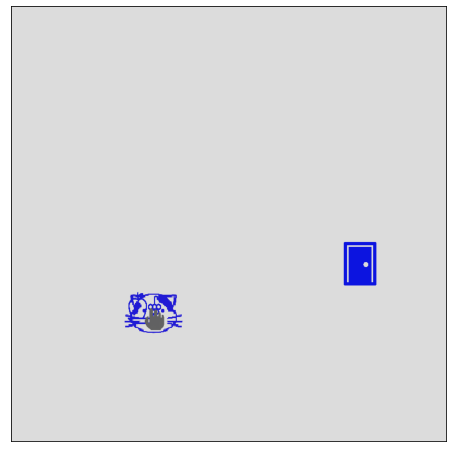

In [10]:
fig = plt.imshow(obs)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

We define two functions. The first one uses the reward function in inference mode in order to compute the probability of reward for each object in the scene. The second is used to generate a random goal which imply the object in the scene. 

In [11]:
def compute_reward_probabilities(state, goal_str, reward_language_model, reward_function, env):
    goal_encoding = reward_language_model.encode(goal_str)
    input_o = torch.tensor(state).float().view(1,len(o))
    input_goal = torch.tensor(goal_encoding).float().view(1,len(goal_encoding))
    reward_per_object = reward_function.reward_function.compute_logits_before_or(input_o, input_goal)
    reward_per_object = [elem.detach()[0][0].item() for elem in reward_per_object]
    objects = [obj.object_descr['colors'] + ' ' + obj.object_descr['types'] for obj in env.objects]
    d = {'Objects':objects, 'Reward':reward_per_object}
    df_rew = pd.DataFrame(d)
    return df_rew

def generate_other_possible_goal(goal_str, env):
    objects = [obj.object_descr['colors'] + ' ' + obj.object_descr['types'] for obj in env.objects]
    other_objects = [o for o in objects if o not in goal_str]
    return ' '.join(random.sample(['Grow'], 1) + random.sample(other_objects, 1))

We recall the achieved goal:

In [12]:
goal_str

'Grow blue cat'

The non-achieved goal involving a distractor object is the following:

In [13]:
other_goal_str = generate_other_possible_goal(goal_str,env)
print(other_goal_str)

Grow blue door


We now plot the object level rewards for these two goals:

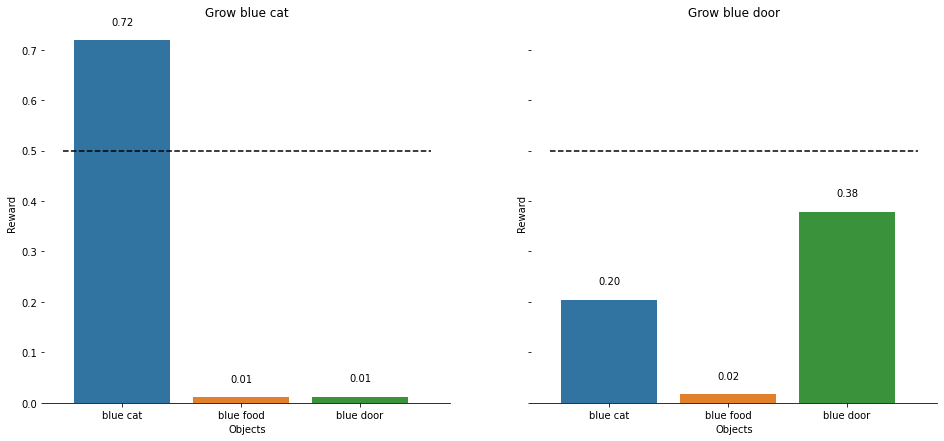

In [14]:
df_rew1 = compute_reward_probabilities(o, goal_str, reward_language_model, reward_function, env)
df_rew2 = compute_reward_probabilities(o, other_goal_str, reward_language_model, reward_function, env)

f, axes = plt.subplots(1, 2, figsize=(16, 7),sharey=True)
sns.despine(left=True)
sns.barplot(x="Objects", y="Reward", data=df_rew1, ax=axes[0]).set_title(goal_str)
for index, row in df_rew1.iterrows():
    axes[0].text(row.name, row.Reward + 0.03, '{:.2f}'.format(row.Reward), color='black', ha="center")
axes[0].plot([-0.5, 2.6], [0.5, 0.5], linestyle='--', color='k')

sns.despine(left=True)
sns.barplot(x="Objects", y="Reward", data=df_rew2, ax=axes[1]).set_title(other_goal_str)
for index, row in df_rew2.iterrows():
    axes[1].text(row.name, row.Reward + 0.03, '{:.2f}'.format(row.Reward), color='black', ha="center")
axes[1].plot([-0.5, 2.6], [0.5, 0.5], linestyle='--', color='k')



Our deepset architecture operating at the object level is confidently detecting the goal achievement (left): $R_{object}>0.5$ (above dashed line).

For the goal that is not fulfilled (right), the architecture correctly predicts that there is no reward for the three objects. However, we can notice that the model outputs a higher signal for the object mentioned in the goal description. This means that the reward function is able to understand which object is used in the goal description without outputting a reward signal > 0.5 if the goal involving this object is not achieved.

#### <strong> 1.2.3 Visualizing the evolution of the object level rewards during rollout </strong>

In this small section we simply look at the evolution of the object level rewards during a rollout. 

In [15]:
%%capture
ani = generate_animation_reward_module(env, goal_str, reward_language_model, reward_function, policy)

In [16]:
HTML(ani.to_html5_video())

### <strong> 1.3 The Policy Module </strong>
------------

#### <strong> 1.3.1 The architecture explained </strong>

The actor and critic architectures are both goal conditioned:
$a=\pi(s,g_{NL})$ and $value=Q(s,a,g_{NL})$.

They follow the same implementation as the reward function. Instead of casting the object features to a scalar like we do for the reward function, the shared-network of the actor and critic casts $s_{obj_i}$ into a high dimensional space. We then use the sum as permutation-invariant function in order to predict the action for the actor and the value for the critic.

The diagram below shows the policy's architecture next to the reward function one. 

Note that the actor and critic are both goal conditioned. However, we do not backpropagate the gradient throught the language encoder during training. The language encoding is only performed by the reward function.


<img src="https://drive.google.com/uc?export=view&id=1zcpO_WtCCQxDpkSbnoRkIwUQM29_tWxC" alt="drawing" width="1000"/>


#### <strong> 1.3.2 Visualizing the norm of the latent vector for each object </strong>

In a similar fashion as we did for the reward function, we propose to look at the norm of the latent vector for each object ($|z_(x_i,g)|$ in the diagram on top) during inference.

In [17]:
%%capture
ani = generate_animation_policy_module(env, goal_str, reward_language_model, policy)

In [18]:
HTML(ani.to_html5_video())

### <strong> 1.4 The Goal Imagination Module </strong>

-------------

Here is the goal imagination module inspired by Construction Grammar. For each pair of known goals that differ by exactly one word, the two differing words are considered equivalent. This means they can be exchanged in any known goal to form a novel goal. 

In [19]:
from src.imagine.goal_generator.simple_sentence_generator import SentenceGeneratorHeuristic
generator = SentenceGeneratorHeuristic(train_descriptions=params['train_descriptions'],
                                       test_descriptions=params['test_descriptions'],
                                       sentences=None, 
                                       method='CGH')
# update the set of known goals
generator.update_model(params['train_descriptions'])
# generate imagined goals
new_descriptions = generator.generate_sentences()

p_found_in_test = sum([d in params['test_descriptions'] for d in new_descriptions]) / len(params['test_descriptions'])
p_not_in_test = sum([d not in params['test_descriptions'] for d in new_descriptions]) / len(new_descriptions)
p_in_test = sum([d in params['test_descriptions'] for d in new_descriptions]) / len(new_descriptions)
print('Percentage of the test set found:', p_found_in_test)
print('Percentage of the new descriptions that are not in the test', p_not_in_test)
print('Percentage of the new descriptions that are in the test set', p_in_test)

data = pd.DataFrame({'Examples of sentences in the generated set, not in the test:': list( set(new_descriptions) - set(params['test_descriptions'])) })
print(data.head(7))

data = pd.DataFrame({'Examples of sentences in the test set, found by generation:': list(set(new_descriptions).intersection(set(params['test_descriptions']))) })
print(data.head(7))

data = pd.DataFrame({'Examples of sentences in the test set, , not in the generated set:': list(set(params['test_descriptions']) - set(new_descriptions)) })
print(data.head(7))


Weird
Percentage of the test set found: 0.875
Percentage of the new descriptions that are not in the test 0.5333333333333333
Percentage of the new descriptions that are in the test set 0.4666666666666667
  Examples of sentences in the generated set, not in the test:
0                                  Grow green carpet          
1                                  Grow green supply          
2                                    Grow blue table          
3                                     Grow any chair          
4                                      Grow any food          
5                                Grow green cupboard          
6                                   Grow blue window          
  Examples of sentences in the test set, found by generation:
0                                    Grasp green dog         
1                                    Grow blue algae         
2                                   Grow green plant         
3                                  Grow gree

## <strong> 2. How to train IMAGINE <strong>

------------
    
In this small section we simply recall the command line that should be used to train all modules of the IMAGINE system in order to replicate results from our paper.

In [20]:
# !python train.py --num_cpu=6 --architecture=modular_attention --imagination_method=CGH --reward_function=learned_lstm  --goal_invention=from_epoch_10 --n_epochs=167

## <strong> 3. Examples of Generalization </strong>

----------------

We now propose to vizualise rollouts of policies conditioned on testing goals.

The Venn Diagram below shows the distribution of training and testing goals. We see that all testing goals cannot be generated by our imagination heurisitc based on constructions grammar. The testing goals that are missing are the sentences containing the 'flower' token. Those goals cannot be generated by the goal imagination module because the 'flower' token is never seen by the agent (never communicated by SP).


<img src="https://drive.google.com/uc?export=view&id=1l1eHKvLIdZlvKRZQhqs9Oj4Gq42xQqWw" alt="drawing" width="500"/>

The list of goals from $\mathcal{G}_\text{test}$ can be obtained as follow:

In [21]:
pd.DataFrame(params['test_descriptions'],columns=['Test goals never communicated by the social partner'])

,Test goals never communicated by the social partner
0,Grasp any animal
1,Grasp any flower
2,Grasp any fly
3,Grasp blue animal
4,Grasp blue door
...,...
59,Grow red living_thing
60,Grow red plant
61,Grow red rose
62,Grow red tea


Among the testing descriptions are goals that involve growing plants. 

In [22]:
# Enter goal here from g_test
g_test = 'Grow blue tea'

In [23]:
%%capture
ani, _, _, _ = generate_animated_rollout(env, g_test, [], policy, policy_language_model, reset=True)

In [24]:
HTML(ani.to_html5_video())

## 4.  Vizualization

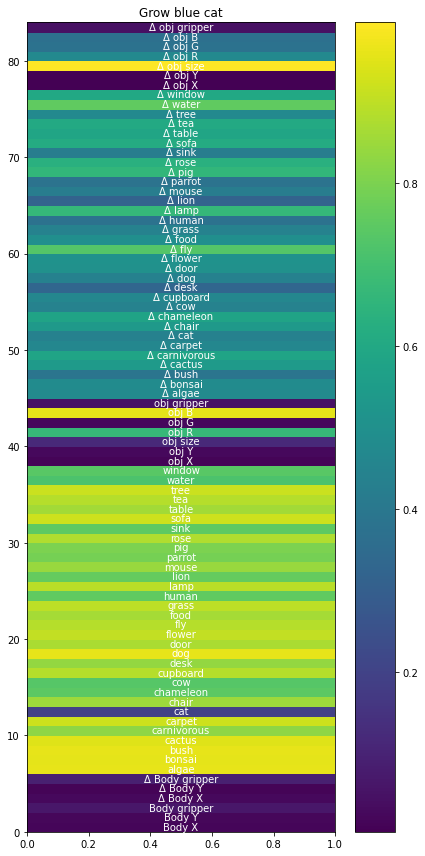

In [25]:
from src.utils.notebook_utils import plot_attention_vector
goal_encoding = torch.tensor(reward_language_model.encode(goal_str))
attention_vector = reward_function.reward_function.get_attention_vector(goal_encoding).detach().numpy()
plot_attention_vector(attention_vector, goal_str, params)

We can visualize the representations of goals learned by the reward functions via a T-SNE projection of the goal embeddings.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

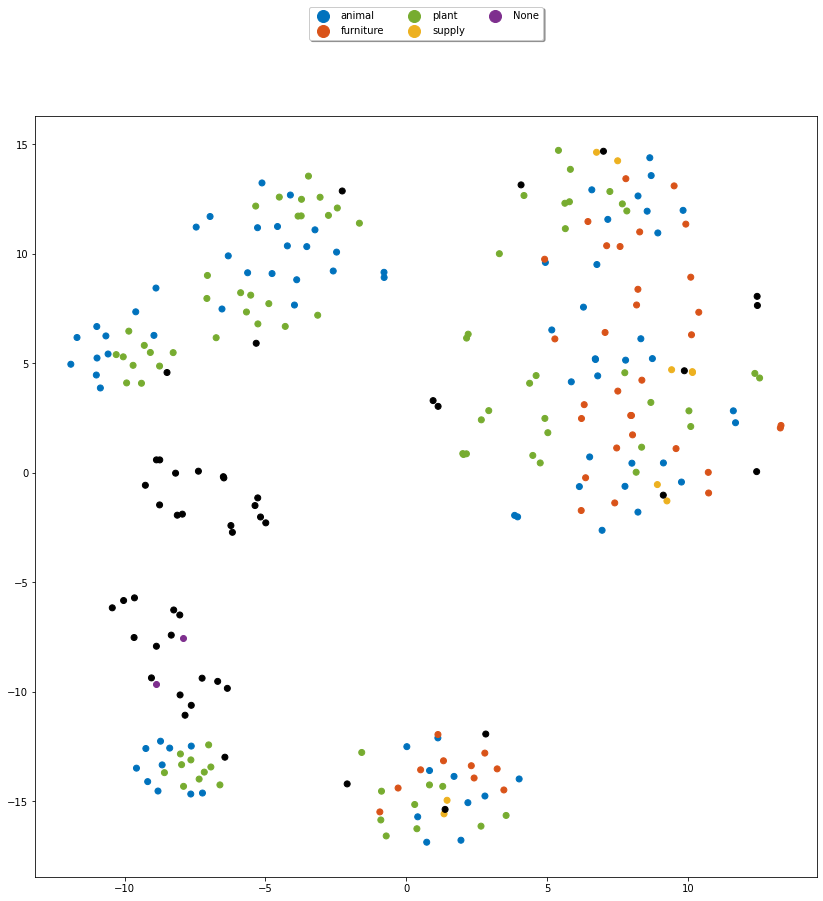

In [26]:
%matplotlib inline
from sklearn.manifold import TSNE
from ipywidgets import interact
code = 'categories'
 
embs = {}
for descr in params['train_descriptions']+params['test_descriptions']:
    goal_encoding = reward_language_model.encode(descr)
    embs[descr]=goal_encoding

descr = sorted(list(embs.keys()))
embeddings = np.array([embs[d] for d in descr])
X_embedded = TSNE(n_components=2,
                  perplexity=20,
                  n_iter=5000,
                  n_iter_without_progress=1000,
                  learning_rate=10).fit_transform(embeddings)
plot_tsne(X_embedded, descr, code, params)
